In [1]:
!pip install bms

    100% |████████████████████████████████| 184kB 531kB/s ta 0:00:01
  Running setup.py bdist_wheel for bms ... done
  Stored in directory: /home/sage/.cache/pip/wheels/c1/c6/2c/6ef998ddafb6af9fc8f47edfd5e652e0777746765f1b76f08a
  Running setup.py bdist_wheel for dill ... done
  Stored in directory: /home/sage/.cache/pip/wheels/27/4b/a2/34ccdcc2f158742cfe9650675560dea85f78c3f4628f7daad0
Successfully built bms dill


In [7]:
import matplotlib.pyplot as plt

1


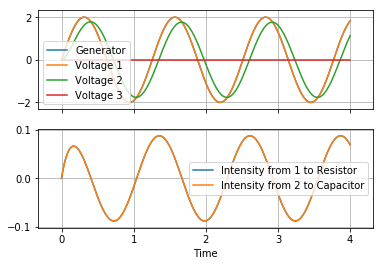

In [8]:
"""
RC circuit with physical modelling
                    _______
           ___1_____|  R   |______ 2
        +_|_        |______|    __|__
        |_G_|                   __ __ C 
        - |_________ _____________| 
                              3
"""

import bms
from bms.physical.electrical import Generator, Resistor, ElectricalNode, Capacitor, Ground
from bms.signals.functions import Sinus

U = Sinus('Generator', 2, 5)  # Voltage of generator
R = 10  # Resistance in Ohm
C = 0.01  # Capacitance in Fahrads

n1 = ElectricalNode('1')
n2 = ElectricalNode('2')
n3 = ElectricalNode('3')

gen = Generator(n3, n1, U)
res = Resistor(n1, n2, R)
cap = Capacitor(n2, n3, C)
gnd = Ground(n3)

ps = bms.PhysicalSystem(4, 300, [gen, res, cap, gnd], [])
ds = ps.dynamic_system

# ds._ResolutionOrder3()
d = ds.Simulate()
ds.PlotVariables([[U, n1.variable, n2.variable, n3.variable],
                  [res.variables[0], cap.variables[0]]])

# Validation: analytical solutions
plt.show()

### first order

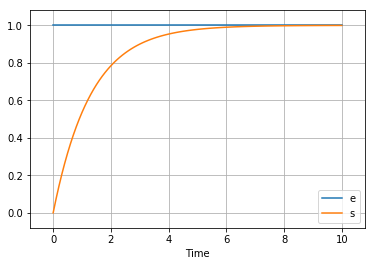

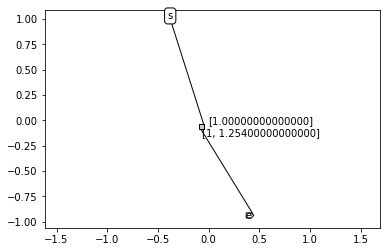

In [15]:
import bms
from bms.signals.functions import Ramp, Step
from bms.blocks.continuous import ODE

K = 1.
tau = 1.254

e = Step('e',1.)
# e = Ramp('e', 1.)
s = bms.Variable('s', [0])

block = ODE(e, s, [K], [1, tau])
ds = bms.DynamicSystem(10, 100, [block])
# res=ds.ResolutionOrder()
# print(res)
ds.Simulate()
ds.PlotVariables()

ds.DrawModel()

plt.show()
# External plot for verification
#import matplotlib.pyplot as plt
#plt.figure()
#plt.plot(ds.t, e.values)
#plt.plot(ds.t, s.values)
#s_inf = K*(ds.t.copy()-tau)
#plt.plot(ds.t, e.values)
#plt.plot(ds.t, s_inf)

### second order

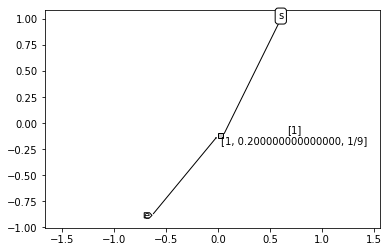

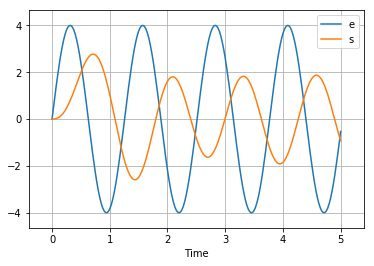

In [6]:
import bms
from bms.signals.functions import Sinus
from bms.blocks.continuous import ODE

K = 1
Q = 0.3
w0 = 3

# e=bms.Step('e',4.)
e = Sinus('e', 4., 5)
s = bms.Variable('s', [0])

block = ODE(e, s, [1], [1, 2*Q/w0, 1/w0**2])
ds = bms.DynamicSystem(5, 200, [block])

ds.DrawModel()
ds.Simulate()
ds.PlotVariables()

plt.show()

### モータ

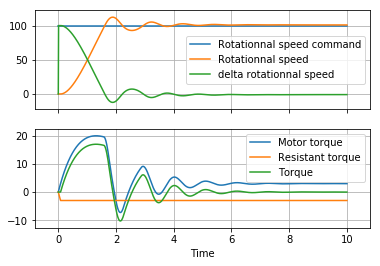

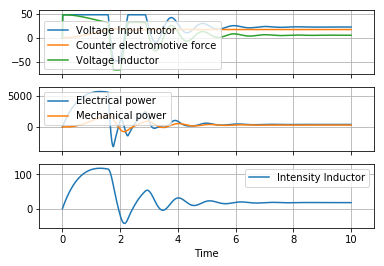

In [10]:
import bms
from bms.signals.functions import Step
from bms.blocks.continuous import Gain, ODE, Sum, Subtraction, Product
from bms.blocks.nonlinear import Coulomb, Saturation

R = 0.3
L = 0.2
J = 0.2
k = 0.17
Tr = 3  # Torque requested on motor output
Gc = 8  # Gain corrector
tau_i = 3
Umax = 48  # Max voltage motor
# Imax=10# Max intensity motor


# e=bmsp.Step(1.,'e')

Wc = Step(('Rotationnal speed command', 'wc'), 100.)

dW = bms.Variable(('delta rotationnal speed', 'dW'))
Up = bms.Variable(('Voltage corrector proportionnal', 'Ucp'))
Ui = bms.Variable(('Voltage corrector integrator', 'Uci'))
Uc = bms.Variable(('Voltage command', 'Uc'))
Um = bms.Variable(('Voltage Input motor', 'Uim'))
e = bms.Variable(('Counter electromotive force', 'Cef'))
Uind = bms.Variable(('Voltage Inductor', 'Vi'))
Iind = bms.Variable(('Intensity Inductor', 'Ii'))
Tm = bms.Variable(('Motor torque', 'Tm'))
Text = bms.Variable(('Resistant torque', 'Tr'))
T = bms.Variable(('Torque', 'T'))
W = bms.Variable(('Rotationnal speed', 'w'))
Pe = bms.Variable(('Electrical power', 'Pe'))
Pm = bms.Variable(('Mechanical power', 'Pm'))


block1 = Subtraction(Wc, W, dW)
block2 = ODE(dW, Ui, [1], [0, tau_i])
block3 = Gain(dW, Up, Gc)
block4 = Sum([Up, Ui], Uc)
block4a = Saturation(Uc, Um, -Umax, Umax)
block5 = Subtraction(Um, e, Uind)
block6 = ODE(Uind, Iind, [1], [R, L])
block7 = Gain(Iind, Tm, k)
block8 = Sum([Tm, Text], T)
block8a = Coulomb(Tm, W, Text, Tr, 2)
block9 = ODE(T, W, [1], [0, J])
block10 = Gain(W, e, k)
block11 = Product(Um, Iind, Pe)
block11a = Product(Tm, W, Pm)
ds = bms.DynamicSystem(10, 1000, [block1, block2, block3, block4, block4a,
                                  block5, block6, block7, block8, block8a, block9, block10, block11, block11a])


# ds.DrawModel()
r = ds.Simulate()
# r=ds._ResolutionOrder()
# print(ba)
ds.PlotVariables([[Wc, W, dW], [Tm, Text, T], ])
ds.PlotVariables([[Um, e, Uind], [Pe, Pm], [Iind]])

plt.show()

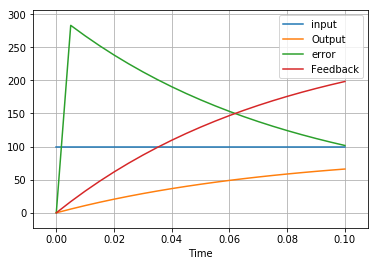

In [11]:
# feedbackの例
import bms
from bms.signals.functions import Step, Sinus
from bms.blocks.continuous import Gain, ODE, Sum, Subtraction, Product, WeightedSum


Ka = 3
Kb = 4
Kc = 3
tau = 1

# ==============================================================================
#  Feedback with derivative for stability test
# ==============================================================================

I = Step(('input', 'i'), 100.)
AI = bms.Variable(('adapted input', 'ai'), [100.])
dI = bms.Variable(('error', 'dI'))
O = bms.Variable(('Output', 'O'))
F = bms.Variable(('Feedback', 'F'))

b1 = Gain(I, AI, Ka)
b2 = WeightedSum([AI, dI], F, [1, -1])
b3 = ODE(O, dI, [1, tau], [Kb])
b4 = Gain(F, O, 1/Kc)
#
# ds.
ds = bms.DynamicSystem(0.1, 20, [b1, b2, b3, b4])
ds.Simulate()
ds.PlotVariables([[I, O, dI, F]])

plt.show()

## 簡単な例

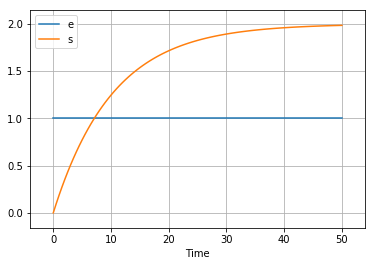

In [21]:
import bms
from bms.signals.functions import Ramp, Step
from bms.blocks.continuous import ODE

e = Step('e',1.)
# e = Ramp('e', 1.)
s = bms.Variable('s', [0])

block = ODE(e, s, [2], [1, 10])
ds = bms.DynamicSystem(50, 100, [block])
# res=ds.ResolutionOrder()
# print(res)
ds.Simulate()
ds.PlotVariables()

#ds.DrawModel()

plt.show()


## PID(simulinkとの対応)
simulinkのモデルをbmsで実行してみます。

<img src="images/pdi_simulink.png" width="450" />

このモデルの実行結果は、以下の通りです。

<img src="images/pdi_simulink_graph.png" width="400" />

### simulinkとのマッピング

| Simulink | bms |
|---|---|
| Step | Step |
| Transfer Fcn | ODE |
| 積分(1/s) | ODE(, , [1], [0, 1]) |
| 微分(s) | ODE(, , [0, 1], [1]) |

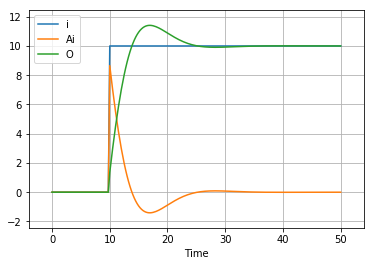

In [57]:
# PIDの例
import bms
from bms.signals.functions import Step, Sinus
from bms.blocks.continuous import Gain, ODE, Sum, Subtraction

Kp = 0.8
Ki = 0.3
Kd = 0.1

I = Step("i", 10, 10)
Ai = bms.Variable("Ai")
Io = bms.Variable("Io")
Do = bms.Variable("Do")
S = bms.Variable("S")
O = bms.Variable("O")

b1 = Subtraction(I, O, Ai)
b2 = ODE(Ai, Io, [1], [0, 1]) # integrator
b3 = ODE(Ai, Do, [0, 1], [1]) # derivative
b4 = WeightedSum([Ai, Io, Do], S, [Kp, Ki, Kd])
b5 = ODE(S, O, [5], [1, 10])

ds = bms.DynamicSystem(50, 200, [b1, b2, b3, b4, b5])
ds.Simulate()
ds.PlotVariables([[I, Ai, O]])

plt.show()